In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Test-time augmentation for uncertainty estimation 

> Compare the uncertainty estimate of the different test-time augmentation methods. The models to compute the results can be found: [Augmented yield prediction models](https://ibm.box.com/v/AugmentedYieldPredictionModels)
You might have to install additional dependencies like `seaborn` to plot the figures. All the models were trained twice to make sure that the results are reproducible. 


In [ ]:
# data
import torch
import os
import pandas as pd
import numpy as np

# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

#plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from IPython.display import display
from IPython.display import set_matplotlib_formats
import seaborn as sns


#models
from rxnfp.models import SmilesClassificationModel
from rxn_yields.data import generate_buchwald_hartwig_rxns
from rxn_yields.augmentation import do_random_permutations_on_df, do_randomizations_on_df

%matplotlib inline
set_matplotlib_formats('svg')
torch.cuda.is_available()

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
This extension has only been tested with simpletransformers==0.34.4


True

In [ ]:
NAME_SPLIT = [
    ('FullCV_01', 2768),
    ('FullCV_02', 2768),
    ('FullCV_03', 2768),
    ('FullCV_04', 2768),
    ('FullCV_05', 2768),
    ('FullCV_06', 2768),
    ('FullCV_07', 2768),
    ('FullCV_08', 2768),
    ('FullCV_09', 2768),
    ('FullCV_10', 2768)]

In [ ]:
# data
y_tests = []
r2_scores = []
rmse_scores = []

y_test_dict = {}

y_preds_dict = {}

for (name, split) in NAME_SPLIT:

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name=name)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)
    
    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] 
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']
    
    y_test = test_df.labels.values
    
    y_test_dict[name] = y_test
    
    

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = SmilesClassificationModel('bert', f'../trained_models/neurips_models/repro_randomsplit/repro_randomsplit_buchwald_hartwig_{name}_perm_5_rand_0_canonical_epochs_10_split_2768_seed_42/checkpoint-8650-epoch-10/',
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
    y_predictions = []
    for manual_seed in range(15):
        augmented_test_df = do_random_permutations_on_df(test_df,
            n_permutations=1,  random_type='', seed=manual_seed)
        
    
        y_preds = model.predict(augmented_test_df.text.values)[0]
    
        y_preds = y_preds * std + mean
        
        y_predictions.append(y_preds)
        
    y_preds_dict[f'{name}_perm5'] = y_predictions
    
    
    model = SmilesClassificationModel('bert', f'../trained_models/neurips_models/repro_randomsplit/repro_randomsplit_buchwald_hartwig_{name}_perm_15_rand_0_rotated_epochs_10_split_2768_seed_42/checkpoint-25950-epoch-10/',
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
    y_predictions = []
    for manual_seed in range(15):
        augmented_test_df = do_random_permutations_on_df(test_df,
            n_permutations=1, random_type='rotated', seed=manual_seed)
        
    
        y_preds = model.predict(augmented_test_df.text.values)[0]
    
        y_preds = y_preds * std + mean
        
        y_predictions.append(y_preds)
        
    y_preds_dict[f'{name}_permrot15'] = y_predictions
    
    
    
    model = SmilesClassificationModel('bert', f'../trained_models/neurips_models/repro_randomsplit/repro_randomsplit_buchwald_hartwig_{name}_perm_0_rand_15_rotated_epochs_10_split_2768_seed_42/checkpoint-25950-epoch-10/',
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
    y_predictions = []
    for manual_seed in range(15):
        augmented_test_df = do_randomizations_on_df(test_df,
            n_randomizations=1,  random_type='rotated', seed=manual_seed)
        
    
        y_preds = model.predict(augmented_test_df.text.values)[0]
    
        y_preds = y_preds * std + mean
        
        y_predictions.append(y_preds)
        
    y_preds_dict[f'{name}_rot15'] = y_predictions
    

In [ ]:
# data 
avg_rhos = [[], [], []]
std_rhos = [[], [], []]

for i in range(2, 11):
    for j, randomization in enumerate(['perm5', 'rot15', 'permrot15']):
        rhos = []
        for name, split in NAME_SPLIT:
            y_test = y_test_dict[name]
            y_predictions = y_preds_dict[f'{name}_{randomization}']
            y_mean = np.mean(y_predictions[:i], axis=0)    
            uncertainty =  np.std(y_predictions[:i], axis=0)
            error = y_test-y_mean
            uncertainty, error = zip(*sorted(zip(uncertainty, error), reverse=True))
            rho, p = stats.spearmanr(uncertainty, np.abs(error))
            rhos.append(rho)
        avg_rhos[j].append(np.mean(rhos))
        std_rhos[j].append(np.std(rhos))
[r[-1] for r in avg_rhos]

[0.4302420145602845, 0.42371870688118846, 0.4180250436583589]

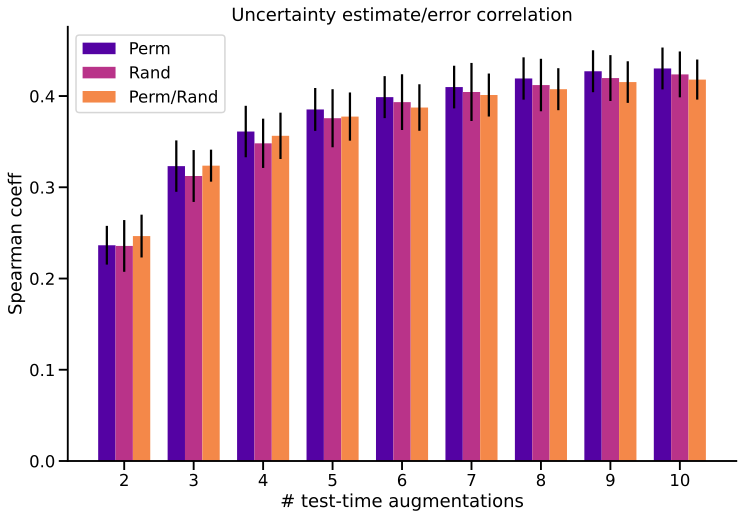

In [ ]:
# data
labels = [str(i) for i in range(2, 11)]
width = 0.25
x0 = np.arange(len(labels))  # the label locations
x1 = [x + width for x in x0]
x2 = [x + width for x in x1]

  # the width of the bars
sns.set_context('talk')

    
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x0, avg_rhos[0], width, label='Perm', yerr=std_rhos[0], color='#5402A3')
rects2 = ax.bar(x1, avg_rhos[1], width, label='Rand', yerr=std_rhos[1], color='#B93389')
rects3 = ax.bar(x2, avg_rhos[2], width, label='Perm/Rand', yerr=std_rhos[2], color='#F48849')

 
ax.set_ylabel('Spearman coeff')
ax.set_xlabel('# test-time augmentations')
ax.set_title('Uncertainty estimate/error correlation')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.legend()
sns.despine()



## Individual plots

In [ ]:
# data 
def make_plot(y_test, y_pred, y_std, rmse, r2_score, mae, uq, name, alpha=0.8, vmax=15, context='paper'):
    sns.set_context(context)
    fontsize = 16
    fig, ax = plt.subplots(figsize=(10,8))
    r2_patch = mpatches.Patch(label="R2 = {:.3f}".format(r2_score), color="#5402A3")
    rmse_patch = mpatches.Patch(label="RMSE = {:.1f}".format(rmse), color="#5402A3")
    mae_patch = mpatches.Patch(label="MAE = {:.1f}".format(mae), color="#5402A3")
    uc_patch = mpatches.Patch(label="UQ = {:.2f}".format(uq), color="#5402A3")
    plt.xlim(-5,105)
    plt.ylim(-5,105)
    oldcmp = plt.cm.get_cmap('twilight', 512)
    newcmp = ListedColormap(oldcmp(np.linspace(0.1, 0.5, 1000)))
    
    im = plt.scatter(y_pred, y_test, alpha=alpha, c=y_std, cmap=newcmp, vmin=0, vmax=vmax)
    plt.plot(np.arange(100), np.arange(100), ls="--", c=".3")
    plt.legend(handles=[r2_patch, rmse_patch, mae_patch, uc_patch], fontsize=fontsize)
    
    plt.colorbar(im, ax=ax)

    ax.set_ylabel('Measured', fontsize=fontsize)
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_title(name, fontsize=fontsize)
    return fig

def analyse_model_on_test_set(test_set, split, seed=1, n_tta=10):
    y_predictions = []
    y_tests = []
    r2_scores = []
    rmse_scores = []

    

    df_doyle = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name=test_set)

    df_doyle['rxn'] = generate_buchwald_hartwig_rxns(df_doyle)

    train_df = df_doyle.iloc[:split-1][['rxn', 'Output']] # paper has starting index 1 not 0
    test_df = df_doyle.iloc[split-1:][['rxn', 'Output']] # paper has starting index 1 not 0

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']

    y_test = test_df.labels.values

    mean = train_df.labels.mean()
    std = train_df.labels.std()
    
    set_type = 'testsplit_multi' if test_set.startswith('Test') else 'randomsplit'
    if split < 2700: set_type = 'discoverysplit'
    
    
    step_dict ={99: 920, 2768: 25950, 3056: 28650, 3058: 28660, 3059: 28670}

    model = SmilesClassificationModel('bert', f'../trained_models/neurips_models/repro_{set_type}/repro_{set_type}_buchwald_hartwig_{test_set}_perm_0_rand_15_rotated_epochs_10_split_{split}_seed_{seed}/checkpoint-{step_dict[split]}-epoch-10/',
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())

    for manual_seed in range(n_tta):
        augmented_test_df = do_randomizations_on_df(test_df,
            n_randomizations=1,  random_type='rotated', seed=manual_seed)


        y_preds = model.predict(augmented_test_df.text.values)[0]

        y_preds = y_preds * std + mean

        y_predictions.append(y_preds)

    # canonical inputs
    y_preds = model.predict(test_df.text.values)[0]
    y_preds = y_preds * std + mean
    y_preds = np.clip(y_preds, 0, 100)
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)

    print('Number of test set augmentations | Spearman correlation coeff between std and error | R2 | MAE | RMSE')
    print(f"0 | - | {r_squared:.3f} | {rmse:.3f} | {mae:.2f}")
    for i in range(2, n_tta+1):
        y_mean = np.mean(y_predictions[:i], axis=0)    
        uncertainty =  np.std(y_predictions[:i], axis=0)
        error = y_test-y_mean
        uncertainty, error = zip(*sorted(zip(uncertainty, error), reverse=True))
        rho, p = stats.spearmanr(uncertainty, np.abs(error))
        r_squared = r2_score(y_test, y_mean)
        rmse = mean_squared_error(y_test, y_mean) ** 0.5
        mae = mean_absolute_error(y_test, y_mean)

        print(f"{i} | {rho:.2f} | {r_squared:.4f} | {rmse:.4f} | {mae:.4f}")

    fig = make_plot(y_test=y_test, y_pred=y_mean, y_std=uncertainty,  rmse=rmse, r2_score=r_squared, mae=mae, uq=rho, name=f'{test_set} - {n_tta}x rand.', alpha=1.0,
                    vmax=4)
    return fig

### Random split - 70% training data

In [ ]:
# data
fig = analyse_model_on_test_set('FullCV_01', 2768, seed=42)

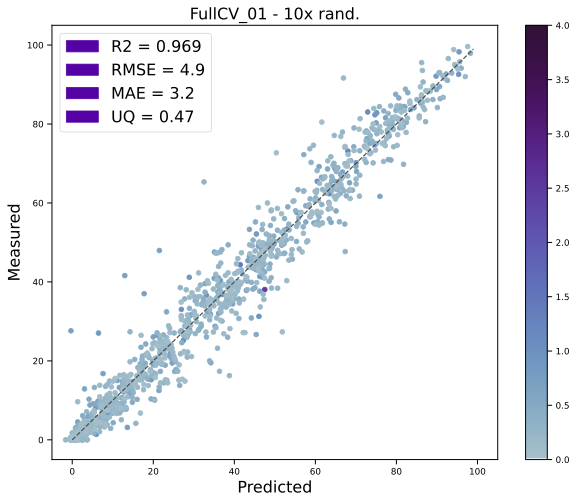

In [ ]:
# data
fig

### Random split - 2.5% training data

In [ ]:
# data
fig = analyse_model_on_test_set('FullCV_01', 99, seed=42)

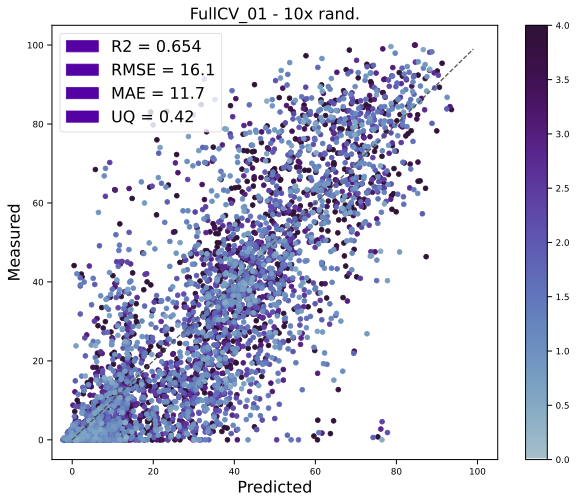

In [ ]:
# data
fig

### Out-of-sample test 1

In [ ]:
# data
fig = analyse_model_on_test_set('Test1', 3058)

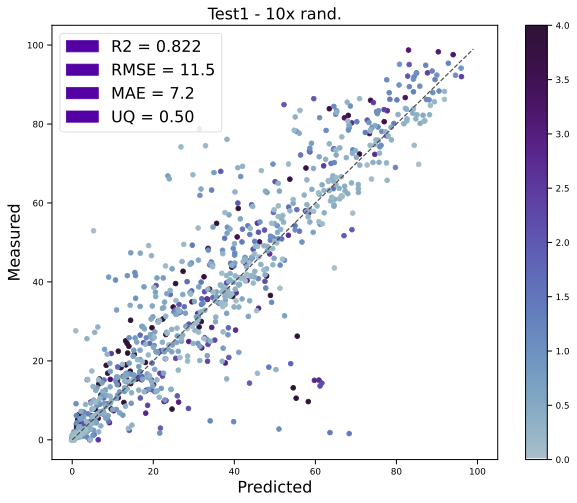

In [ ]:
# data
fig

### Out-of-sample test 2

In [ ]:
# data 
fig = analyse_model_on_test_set('Test2', 3056)

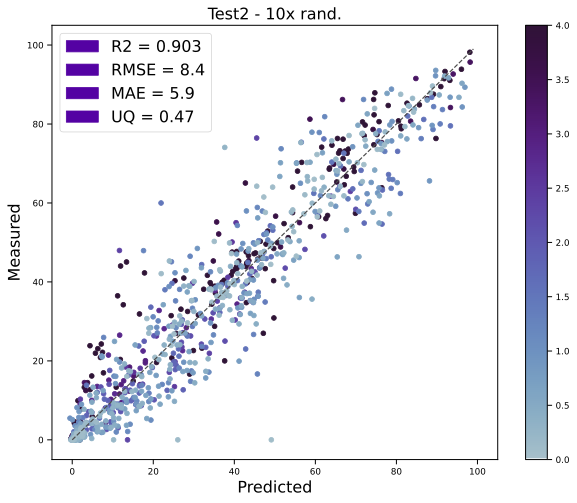

In [ ]:
# data
fig

### Out-of-sampel test 3 

In [ ]:
# data
fig = analyse_model_on_test_set('Test3', 3059)

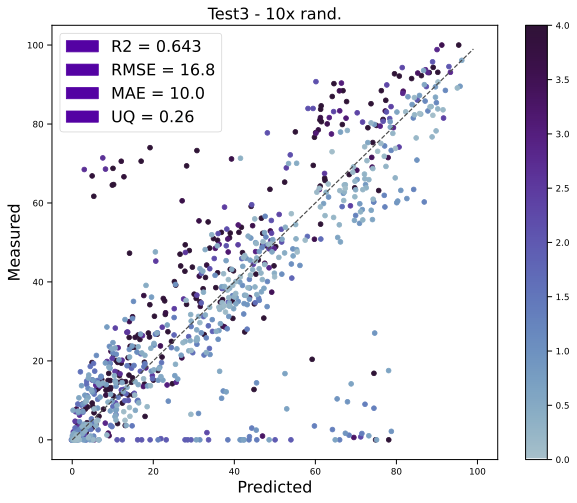

In [ ]:
# data
fig

### Out-of-sample test 4 

In [ ]:
# data
fig = analyse_model_on_test_set('Test4', 3056)

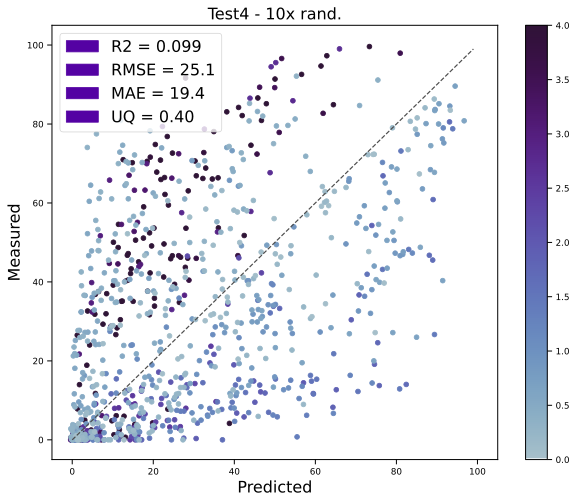

In [ ]:
# data
fig